Procesando Datos Locales (Excel)
Advertencia: COLCAP_Index parece estar en puntos brutos. Se recomienda escalar a base 100 para un cálculo de retornos consistente.
Datos de TES y COLCAP (desde Excel) procesados correctamente.

Descargando Datos de Yahoo Finance
Columnas descargadas y procesadas: ['CIB', 'COP=X', 'EC', 'EEM', 'IAU', 'VOO']
¡Todos los tickers se descargaron correctamente!
Alineación y Conversión de Moneda (FX)
Cálculo de Retornos y Métricas
Pesos ajustados para activos disponibles: [0.2  0.05 0.05 0.2  0.1  0.05 0.2  0.15]

Resultados del Portafolio (Horizonte 5 años):
---------------------------------------------
Retorno Esperado Anualizado: 6.82%
Volatilidad Anualizada (Riesgo): 13.55%
Ratio de Sharpe (asumiendo Rf=0 para simplificar): 0.50
Visualizaciones


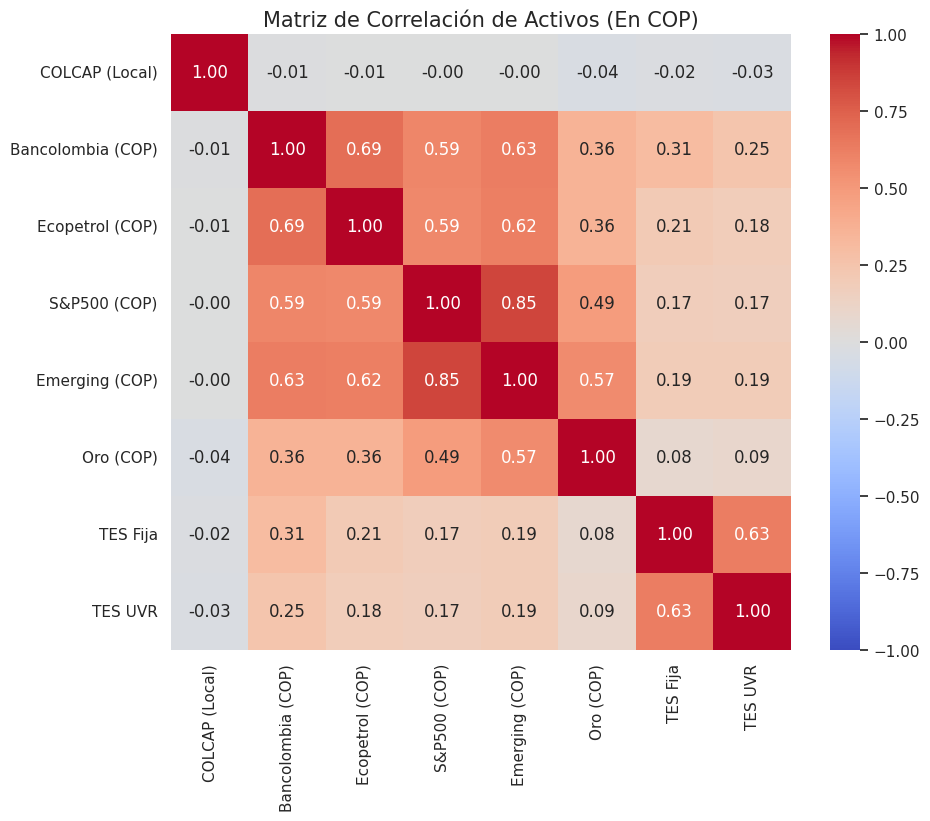

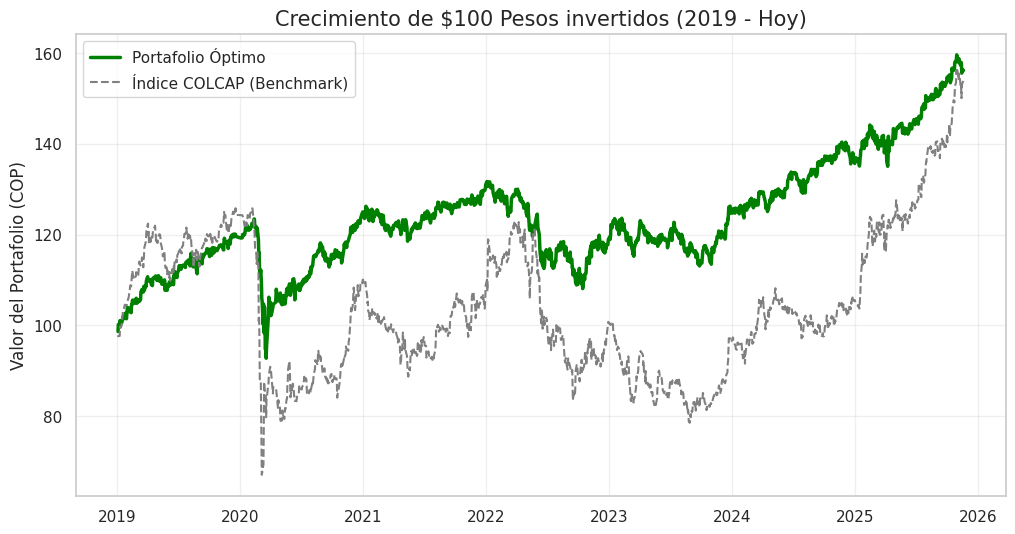

Generando simulación de Monte Carlo (5,000 portafolios)...


/tmp/ipython-input-2556836664.py:294: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (ind_vols[i], ind_rets[i]), xytext=(5, 5), textcoords='offset points', fontsize=9, weight='bold')


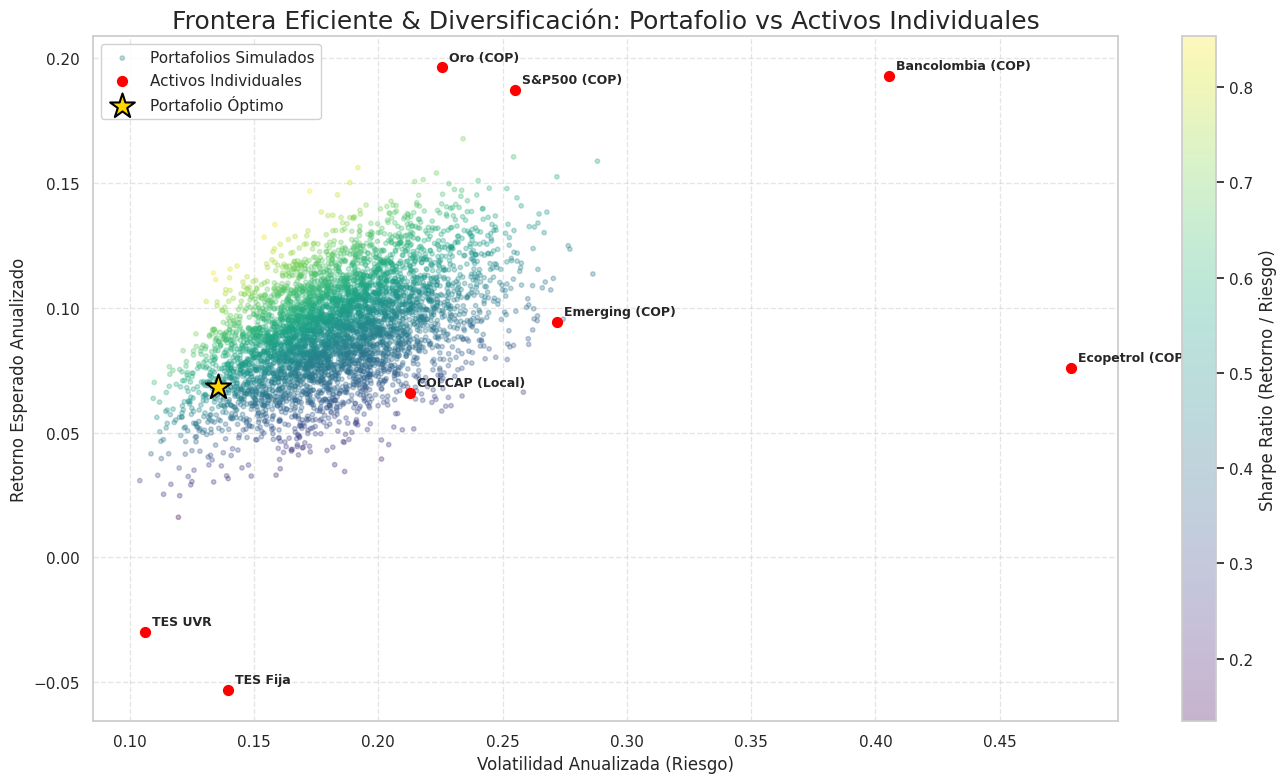

In [24]:
# Instalamos yfinance
!pip install --upgrade yfinance --no-cache-dir

import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Configuración de estilo para gráficos profesionales
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Definimos los Tickers.
tickers_locales = ['CIB', 'EC'] # COLCAP se cargará desde Excel
tickers_int = ['VOO', 'EEM', 'IAU']
ticker_trm = ['COP=X']

# Lista completa para descarga
todos_tickers = tickers_locales + tickers_int + ticker_trm

# Pesos del Portafolio (Orden Estricto para la Matriz)
# 1.Colcap, 2.Bancol, 3.Ecop, 4.VOO, 5.EEM, 6.Oro, 7.TesFija, 8.TesUVR
weights = np.array([0.20, 0.05, 0.05, 0.20, 0.10, 0.05, 0.20, 0.15])

# Verificar que los pesos sumen 1 (100%)
assert np.isclose(weights.sum(), 1.0), "¡Error! Los pesos no suman 100%"

start_date = '2019-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

print("Procesando Datos Locales (Excel)")
try:
    # Cargar Excel
    df_tes = pd.read_excel('tasas_banrep.xlsx')

    # Asegurar formato fecha
    df_tes['Fecha'] = pd.to_datetime(df_tes['Fecha'])
    df_tes.set_index('Fecha', inplace=True)

    # Limpieza: Si las tasas vienen en formato 10.5 (%), dividir por 100.
    cols_tasas = ['Tasa_Fija', 'Tasa_UVR']
    for col in cols_tasas:
        if col in df_tes.columns and df_tes[col].mean() > 1:
            df_tes[col] = df_tes[col] / 100

    if 'COLCAP_Index' in df_tes.columns and df_tes['COLCAP_Index'].mean() > 1000:
        print("Advertencia: COLCAP_Index parece estar en puntos brutos. Se recomienda escalar a base 100 para un cálculo de retornos consistente.")

    # TRANSFORMACIÓN: Yield to Price (Duración Constante)
    # Esto simula cómo se mueve el precio del bono ante cambios en la tasa.
    duracion_fija = 7
    duracion_uvr = 8

    df_tes['TES_Fija_Price'] = 100 / ((1 + df_tes['Tasa_Fija']) ** duracion_fija)
    df_tes['TES_UVR_Price'] = 100 / ((1 + df_tes['Tasa_UVR']) ** duracion_uvr)

    # Nos quedamos solo con los precios simulados y el COLCAP del Excel
    excel_cols_to_keep = ['TES_Fija_Price', 'TES_UVR_Price']
    if 'COLCAP_Index' in df_tes.columns:
        excel_cols_to_keep.append('COLCAP_Index')
    df_tes_clean = df_tes[excel_cols_to_keep].dropna()
    print("Datos de TES y COLCAP (desde Excel) procesados correctamente.")

except Exception as e:
    print(f"ERROR CRÍTICO leyendo el Excel: {e}")
    print("Por favor verifica que subiste 'tasas_banrep.xlsx' y tiene el formato correcto, incluyendo 'COLCAP_Index' si lo has añadido.")

print("\nDescargando Datos de Yahoo Finance")

# Descarga bruta de todos los tickers a la vez
datos_raw = yf.download(todos_tickers, start=start_date, end=end_date, auto_adjust=False, progress=False)

# Verificación y Selección de 'Adj Close'
if isinstance(datos_raw.columns, pd.MultiIndex):
    df_yahoo = datos_raw['Adj Close'].copy()
else:
    df_yahoo = datos_raw.copy()

# Rellenar datos faltantes (Fines de semana/Festivos)
df_yahoo = df_yahoo.ffill()

# Eliminar columnas que estén completamente vacías después del ffill
df_yahoo = df_yahoo.dropna(axis=1, how='all')

# Diagnóstico de descarga
successful_tickers = df_yahoo.columns.tolist()
failed_tickers = [t for t in todos_tickers if t not in successful_tickers]

if successful_tickers:
    print(f"Columnas descargadas y procesadas: {successful_tickers}")
    if failed_tickers:
        print(f"¡ALERTA! No se pudieron descargar completamente o contenían errores: {failed_tickers}")
    else:
        print("¡Todos los tickers se descargaron correctamente!")
else:
    df_yahoo = pd.DataFrame()
    print("ERROR: No se descargaron datos de Yahoo Finance. Por favor, verifica los símbolos y la conexión.")

print("Alineación y Conversión de Moneda (FX)")

# Unir Yahoo con TES
if not df_yahoo.empty and not df_tes_clean.empty:
    df_total = df_yahoo.join(df_tes_clean, how='inner')

    if df_total.empty:
        print("Advertencia: df_total está vacío después del join. Revisa las fechas y disponibilidad de datos.")
else:
    df_total = pd.DataFrame()
    print("Advertencia: df_yahoo o df_tes_clean está vacío, no se puede crear df_total.")

if not df_total.empty:
    # Asegurar que accedemos a la columna TRM correctamente.
    trm_col = pd.Series(1, index=df_total.index)
    if 'COP=X' in df_total.columns:
        trm_col = df_total['COP=X']
    else:
        print("Advertencia: No se encuentra la tasa de cambio 'COP=X'. Las conversiones a COP no se realizarán.")

    # Conversión a Pesos Colombianos (COP)
    if 'VOO' in df_total.columns:
        df_total['VOO_COP'] = df_total['VOO'] * trm_col
    if 'EEM' in df_total.columns:
        df_total['EEM_COP'] = df_total['EEM'] * trm_col
    if 'IAU' in df_total.columns:
        df_total['IAU_COP'] = df_total['IAU'] * trm_col

    if 'CIB' in df_total.columns:
        df_total['CIB_COP'] = df_total['CIB'] * trm_col
    if 'EC' in df_total.columns:
        df_total['EC_COP'] = df_total['EC'] * trm_col


    # Selección final de columnas en el ORDEN DE LOS PESOS
    cols_finales = [
        'COLCAP_Index',
        'CIB_COP',
        'EC_COP',
        'VOO_COP',
        'EEM_COP',
        'IAU_COP',
        'TES_Fija_Price',
        'TES_UVR_Price'
    ]

    # Filtrar cols_finales para incluir solo las columnas que realmente existen en df_total
    existing_cols_finales = [col for col in cols_finales if col in df_total.columns]
    if len(existing_cols_finales) != len(cols_finales):
        missing_final_cols = set(cols_finales) - set(existing_cols_finales)
        print(f"Advertencia: Algunas columnas finales del portafolio están ausentes: {missing_final_cols}. Los cálculos podrían ser incompletos.")

    portfolio_prices = df_total[existing_cols_finales].copy()

    # Renombrar para que el gráfico se vea bonito
    nombres_limpios_map = {
        'COLCAP_Index': 'COLCAP (Local)',
        'CIB_COP': 'Bancolombia (COP)',
        'EC_COP': 'Ecopetrol (COP)',
        'VOO_COP': 'S&P500 (COP)',
        'EEM_COP': 'Emerging (COP)',
        'IAU_COP': 'Oro (COP)',
        'TES_Fija_Price': 'TES Fija',
        'TES_UVR_Price': 'TES UVR'
    }
    # Mapear solo las columnas existentes a nombres limpios
    portfolio_prices.columns = [nombres_limpios_map.get(col, col) for col in portfolio_prices.columns]

    print("Cálculo de Retornos y Métricas")
    # Retornos Logarítmicos
    log_returns = np.log(portfolio_prices / portfolio_prices.shift(1)).dropna()

    # Ajustar pesos basados en los activos disponibles
    original_asset_names_in_order = [
        'COLCAP (Local)', 'Bancolombia (COP)', 'Ecopetrol (COP)', 'S&P500 (COP)', 'Emerging (COP)',
        'Oro (COP)', 'TES Fija', 'TES UVR'
    ]
    original_weights_map = dict(zip(original_asset_names_in_order, weights))

    filtered_weights = []
    for col_name in log_returns.columns:
        if col_name in original_weights_map:
            filtered_weights.append(original_weights_map[col_name])

    current_weights = np.array(filtered_weights)

    # Re-normalizar pesos si se filtraron activos
    if np.isclose(current_weights.sum(), 0.0) or len(current_weights) == 0:
        print("ERROR: La suma de pesos ajustados es cero o no hay activos disponibles. No se pueden calcular métricas.")
        can_calculate_portfolio = False
    else:
        current_weights = current_weights / current_weights.sum()
        print(f"Pesos ajustados para activos disponibles: {current_weights}")
        can_calculate_portfolio = True


    # Verificar si log_returns está vacío antes de los cálculos
    if can_calculate_portfolio and not log_returns.empty and len(log_returns.columns) == len(current_weights):
        # 1. Retorno Esperado Anualizado
        avg_daily_ret = log_returns.mean()
        portfolio_return_annual = np.sum(avg_daily_ret * current_weights) * 252

        # 2. Matriz de Covarianza Anualizada
        cov_matrix_annual = log_returns.cov() * 252

        # 3. Volatilidad del Portafolio (Desviación Estándar)
        portfolio_volatility = np.sqrt(np.dot(current_weights.T, np.dot(cov_matrix_annual, current_weights)))

        print(f"\nResultados del Portafolio (Horizonte 5 años):")
        print(f"---------------------------------------------")
        print(f"Retorno Esperado Anualizado: {portfolio_return_annual:.2%}")
        print(f"Volatilidad Anualizada (Riesgo): {portfolio_volatility:.2%}")
        print(f"Ratio de Sharpe (asumiendo Rf=0 para simplificar): {portfolio_return_annual/portfolio_volatility:.2f}")

        print("Visualizaciones")

        # MAPA DE CORRELACIONES
        plt.figure(figsize=(10, 8))
        sns.heatmap(log_returns.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
        plt.title('Matriz de Correlación de Activos (En COP)', fontsize=15)
        plt.show()

        # DESEMPEÑO HISTÓRICO (BASE 100)
        weighted_returns = (log_returns * current_weights).sum(axis=1)
        portfolio_cum_ret = np.exp(weighted_returns.cumsum()) * 100

        if 'COLCAP (Local)' in log_returns.columns:
            colcap_cum_ret = np.exp(log_returns['COLCAP (Local)'].cumsum()) * 100

            plt.figure(figsize=(12, 6))
            plt.plot(portfolio_cum_ret, label='Portafolio Óptimo', linewidth=2.5, color='green')
            plt.plot(colcap_cum_ret, label='Índice COLCAP (Benchmark)', linewidth=1.5, color='gray', linestyle='--')
            plt.title('Crecimiento de $100 Pesos invertidos (2019 - Hoy)', fontsize=15)
            plt.ylabel('Valor del Portafolio (COP)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        else:
            print("Advertencia: Datos de COLCAP no disponibles, no se puede graficar el benchmark.")

        # VISUALIZACIÓN AVANZADA: FRONTERA EFICIENTE (MONTE CARLO)

        print("Generando simulación de Monte Carlo (5,000 portafolios)...")

        # Preparación de Datos
        num_portfolios = 5000
        all_weights = np.zeros((num_portfolios, len(portfolio_prices.columns)))
        ret_arr = np.zeros(num_portfolios)
        vol_arr = np.zeros(num_portfolios)
        sharpe_arr = np.zeros(num_portfolios)

        # Retornos medios anualizados y matriz de covarianza
        mean_ret = log_returns.mean() * 252
        cov_mat = log_returns.cov() * 252

        # Simulación (Loop)
        np.random.seed(42)

        for i in range(num_portfolios):
            # Generar pesos aleatorios
            w = np.random.random(len(portfolio_prices.columns))
            w = w / np.sum(w) # Normalizar para que sumen 1

            # Guardar pesos
            all_weights[i,:] = w

            # Calcular métricas
            ret_arr[i] = np.sum(mean_ret * w)
            vol_arr[i] = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

            # Sharpe Ratio
            sharpe_arr[i] = ret_arr[i] / vol_arr[i]

        # Datos de Activos Individuales
        ind_rets = mean_ret
        ind_vols = np.sqrt(np.diag(cov_mat))

        # Datos de TU Portafolio V2.0
        my_port_ret = portfolio_return_annual
        my_port_vol = portfolio_volatility

        # Graficar
        plt.figure(figsize=(14, 8))

        # La Nube de Monte Carlo (Coloreada por Sharpe Ratio)
        sc = plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', alpha=0.3, s=10, label='Portafolios Simulados')
        plt.colorbar(sc, label='Sharpe Ratio (Retorno / Riesgo)')

        # Los Activos Individuales (Puntos Rojos)
        plt.scatter(ind_vols, ind_rets, c='red', s=50, marker='o', label='Activos Individuales')

        # Etiquetas para cada activo
        for i, txt in enumerate(portfolio_prices.columns):
            plt.annotate(txt, (ind_vols[i], ind_rets[i]), xytext=(5, 5), textcoords='offset points', fontsize=9, weight='bold')

        # TU PORTAFOLIO V2.0
        plt.scatter(my_port_vol, my_port_ret, c='gold', s=350, marker='*', edgecolors='black', linewidth=1.5, label='Portafolio Óptimo', zorder=10)

        # Cosmética del Gráfico
        plt.title('Frontera Eficiente & Diversificación: Portafolio vs Activos Individuales', fontsize=18)
        plt.xlabel('Volatilidad Anualizada (Riesgo)', fontsize=12)
        plt.ylabel('Retorno Esperado Anualizado', fontsize=12)
        plt.legend(loc='upper left', frameon=True, fancybox=True, framealpha=0.9)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

    else:
        print("Advertencia: Datos históricos insuficientes o discrepancia en el número de activos y pesos. Se omiten cálculos y visualizaciones.")
else:
    print("Advertencia: df_total está vacío o faltan datos críticos. Se omiten cálculos y visualizaciones del portafolio.")

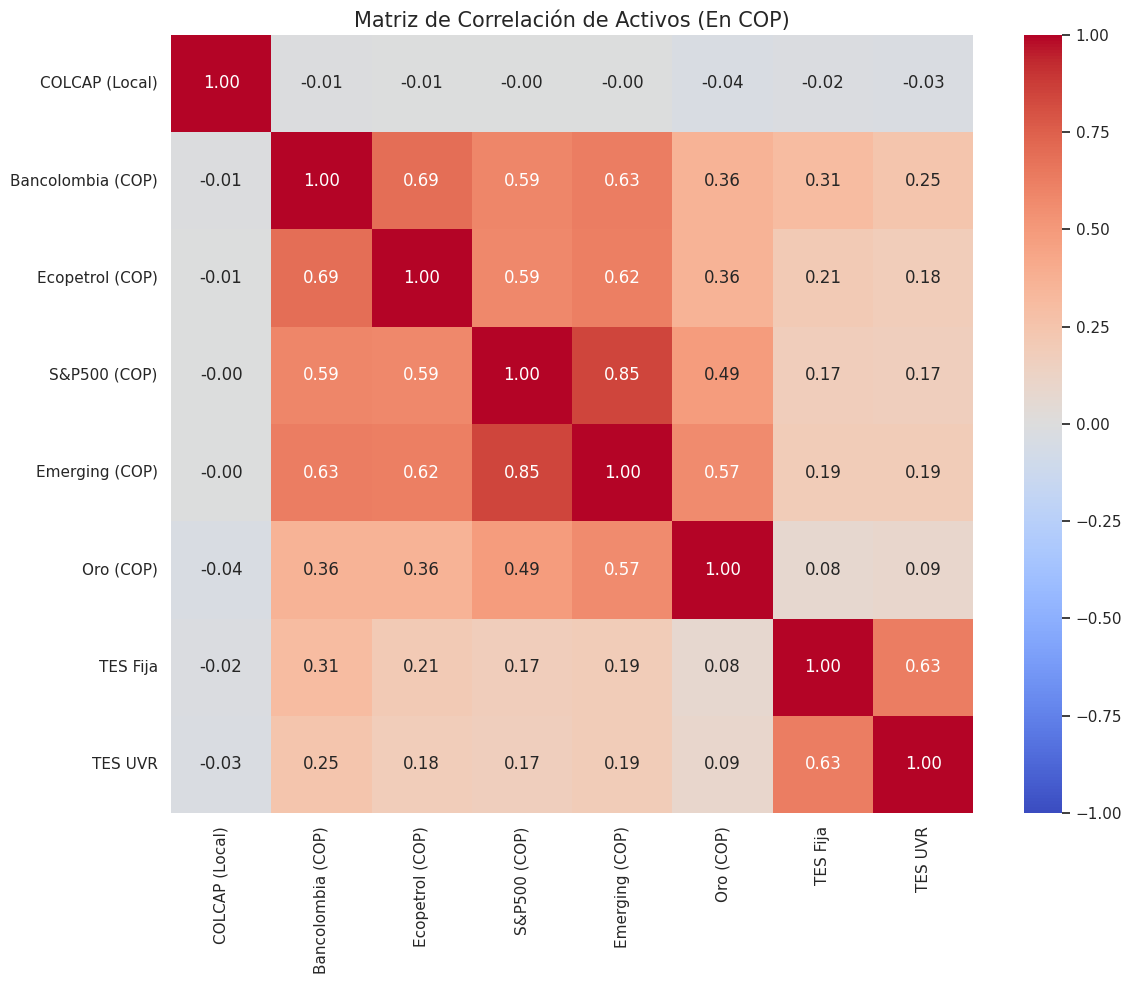

Gráfica 'correlacion_activos.png' guardada.


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(log_returns.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Activos (En COP)', fontsize=15)
plt.tight_layout()
plt.savefig('correlacion_activos.png', bbox_inches='tight')
plt.show()

print("Gráfica 'correlacion_activos.png' guardada.")

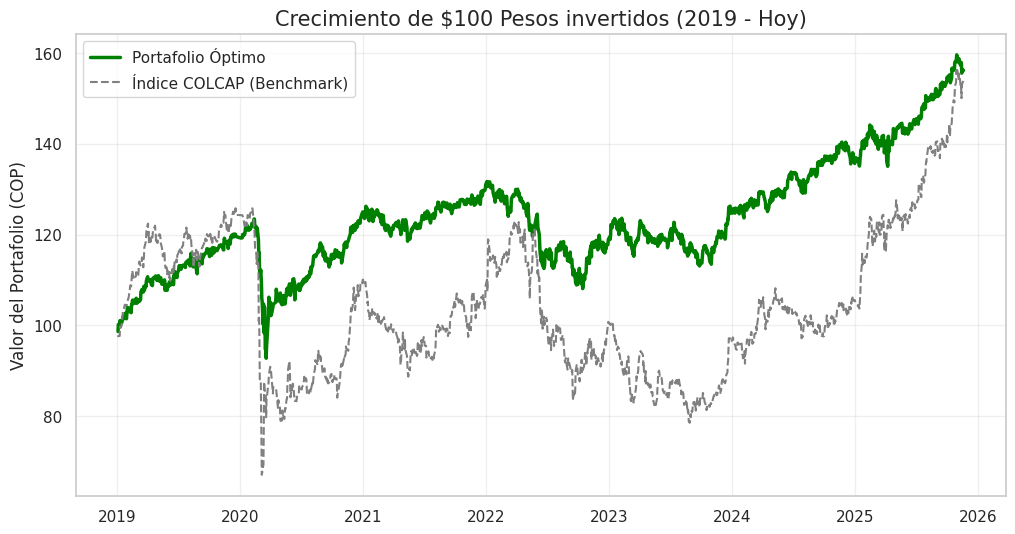

Gráfica 'desempeno_historico.png' guardada.


In [26]:
import matplotlib.pyplot as plt
import numpy as np

weighted_returns = (log_returns * current_weights).sum(axis=1)
portfolio_cum_ret = np.exp(weighted_returns.cumsum()) * 100

if 'COLCAP (Local)' in log_returns.columns:
    colcap_cum_ret = np.exp(log_returns['COLCAP (Local)'].cumsum()) * 100

    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_cum_ret, label='Portafolio Óptimo', linewidth=2.5, color='green')
    plt.plot(colcap_cum_ret, label='Índice COLCAP (Benchmark)', linewidth=1.5, color='gray', linestyle='--')
    plt.title('Crecimiento de $100 Pesos invertidos (2019 - Hoy)', fontsize=15)
    plt.ylabel('Valor del Portafolio (COP)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('desempeno_historico.png')
    plt.show()
    print("Gráfica 'desempeno_historico.png' guardada.")
else:
    print("Advertencia: Datos de COLCAP no disponibles, no se puede graficar el benchmark.")

/tmp/ipython-input-2060630160.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (ind_vols[i], ind_rets[i]), xytext=(5, 5), textcoords='offset points', fontsize=9, weight='bold')


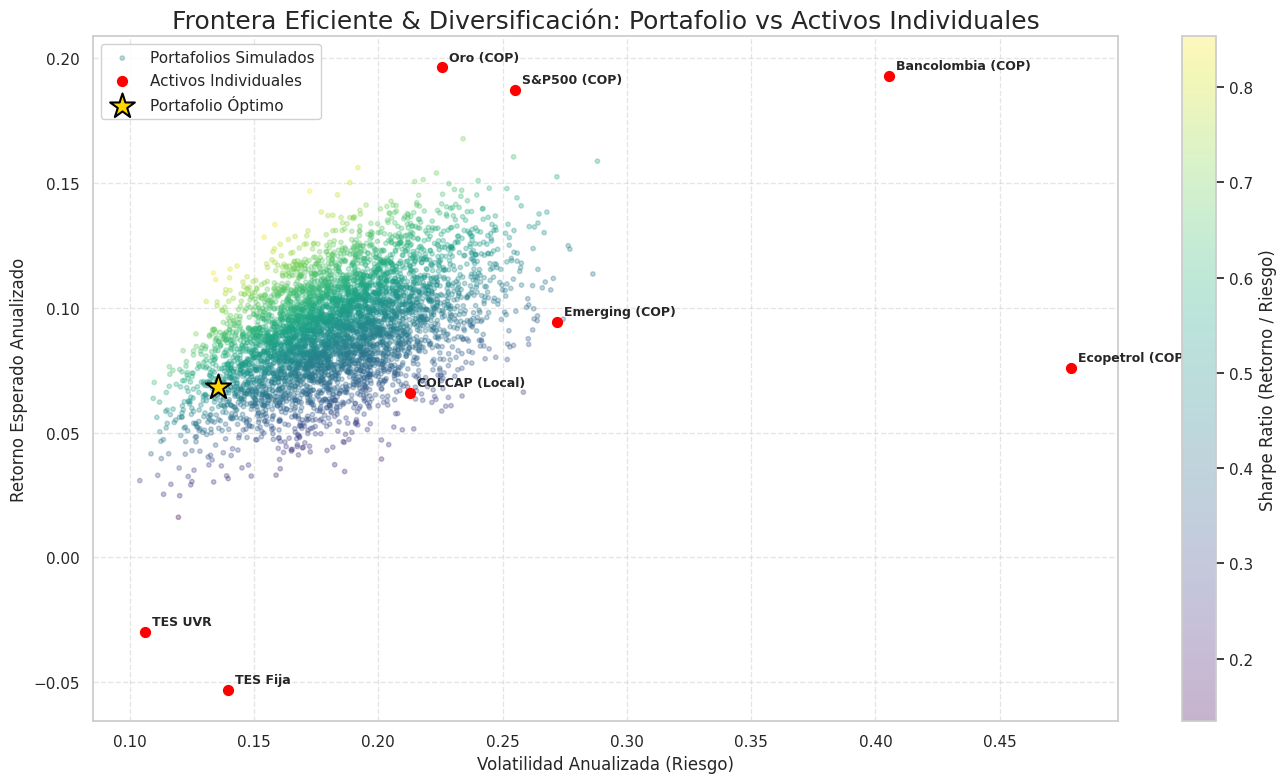

Gráfica 'frontera_eficiente.png' guardada.


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

num_portfolios = 5000
all_weights = np.zeros((num_portfolios, len(portfolio_prices.columns)))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

mean_ret = log_returns.mean() * 252
cov_mat = log_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    w = np.random.random(len(portfolio_prices.columns))
    w = w / np.sum(w)

    all_weights[i,:] = w

    ret_arr[i] = np.sum(mean_ret * w)
    vol_arr[i] = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

    sharpe_arr[i] = ret_arr[i] / vol_arr[i]

ind_rets = mean_ret
ind_vols = np.sqrt(np.diag(cov_mat))

my_port_ret = portfolio_return_annual
my_port_vol = portfolio_volatility

plt.figure(figsize=(14, 8))
sc = plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis', alpha=0.3, s=10, label='Portafolios Simulados')
plt.colorbar(sc, label='Sharpe Ratio (Retorno / Riesgo)')
plt.scatter(ind_vols, ind_rets, c='red', s=50, marker='o', label='Activos Individuales')

for i, txt in enumerate(portfolio_prices.columns):
    plt.annotate(txt, (ind_vols[i], ind_rets[i]), xytext=(5, 5), textcoords='offset points', fontsize=9, weight='bold')

plt.scatter(my_port_vol, my_port_ret, c='gold', s=350, marker='*', edgecolors='black', linewidth=1.5, label='Portafolio Óptimo', zorder=10)

plt.title('Frontera Eficiente & Diversificación: Portafolio vs Activos Individuales', fontsize=18)
plt.xlabel('Volatilidad Anualizada (Riesgo)', fontsize=12)
plt.ylabel('Retorno Esperado Anualizado', fontsize=12)
plt.legend(loc='upper left', frameon=True, fancybox=True, framealpha=0.9)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('frontera_eficiente.png')
plt.show()

print("Gráfica 'frontera_eficiente.png' guardada.")